Set 1: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)

#Importing necessary libraries

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import seaborn as sns

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#Importing glove vectors

In [ ]:
#please use below code to load glove vectors 
with open('/content/drive/MyDrive/9_Donors_choose_DT/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

#Importing data

In [ ]:
file_path = "/content/drive/MyDrive/9_Donors_choose_DT/preprocessed_data.csv"

In [ ]:
preprocessed_data = pd.read_csv(file_path, nrows=35000)
preprocessed_data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [ ]:
x = preprocessed_data.drop(columns=['project_is_approved'])
y = preprocessed_data['project_is_approved']

In [ ]:
print("x =", x.shape, "y =", y.shape)

x = (35000, 8) y = (35000,)


In [ ]:
sid = SentimentIntensityAnalyzer()
negative = []
positive = []
neutral = []
compound = []

def update_sentiments(values):
    negative.append(values["neg"])    
    positive.append(values["pos"])
    neutral.append(values["neu"])
    compound.append(values["compound"])

for essay in tqdm(x["essay"]):
    update_sentiments(sid.polarity_scores(essay))

100%|██████████| 35000/35000 [01:22<00:00, 426.30it/s]


In [ ]:
x["neg"] = negative
x["pos"] = positive
x["neu"] = neutral       
x["compound"] = compound

x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42,test_size = 0.33)

In [ ]:
print("x_train =", x_train.shape, "y_train =", y_train.shape)
print("x_test =", x_test.shape, "y_test =", y_test.shape)

x_train = (23450, 12) y_train = (23450,)
x_test = (11550, 12) y_test = (11550,)


#Featurization of categorical feature


## Response coding fit and transform functions

In [ ]:
def response_coding_fit(x,y,fea):
  """Fit method for response coding.
  This """
  assert type(fea)==str
  assert len(x) == len(y)
  y_dict = dict(y.value_counts())
  #print(y_dict)
  fea_dict = dict(x[fea].value_counts())
  #print(fea_dict)
  concat_series = pd.Series(data = (x[fea].astype(str) + y.astype(str)))
  concat_dict = dict(concat_series.value_counts())
  #print(concat_dict)

  for fea_key in sorted(fea_dict.keys()):
    concat_dict.update({fea_key+'0':0}) if (fea_key+'0') not in list(concat_dict.keys()) else None
    concat_dict.update({fea_key+'1':0}) if (fea_key+'1') not in list(concat_dict.keys()) else None
      
  tmp_dict = {}
  for fea_key in sorted(fea_dict.keys()):
    tmp_lst = []
    #print(fea_key)
    for concat_key in sorted(concat_dict.keys()):
      #print(concat_key)
      if concat_key[:-1] == fea_key and int(concat_key[-1]) == 0:
        #print("condition1",concat_dict[concat_key],y_dict[0],concat_dict[concat_key]/y_dict[0])
        tmp_lst.append(concat_dict[concat_key]/fea_dict[fea_key])
      if concat_key[:-1] == fea_key and int(concat_key[-1]) == 1:
        #print("condition2",concat_dict[concat_key],y_dict[1],concat_dict[concat_key]/y_dict[1])
        tmp_lst.append(concat_dict[concat_key]/fea_dict[fea_key])
    tmp_dict.update({fea_key:tmp_lst})
  return tmp_dict
  
  

In [ ]:
def response_coding_transform(x,response_dict,fea):
  assert type(fea)==str
  fea_dict = dict(x[fea].value_counts())
  for ele in sorted(fea_dict.keys()):
    if ele not in response_dict.keys():
      response_dict.update({ele:[0.5,0.5]})
  tmp_lst = []
  for ele in x[fea]:
    for response_key in list(response_dict.keys()):
      if ele== response_key:
        #print(ele,tmp_dict[key])
        tmp_lst.append(response_dict[response_key])

  x[[fea+'_0',fea+'_1']] = pd.DataFrame(tmp_lst,index=x.index)
  return x

##Response coding test

In [ ]:
data = {'col':['aa','bb','cc','dd','aa','bb','cc','dd'],'op':[0,0,0,1,1,0,1,0]}
x_df = pd.DataFrame(data)
data = {'col':['aa','bb','cc','dd','aa','bb','ee','dd'],'op':[0,0,0,1,1,0,1,0]}
x_df2 = pd.DataFrame(data)
response_dict = response_coding_fit(x_df,x_df['op'],'col')
response_dict
df_op = response_coding_transform(x_df2,response_dict,'col')
df_op

,col,op,col_0,col_1
0,aa,0,0.5,0.5
1,bb,0,1.0,0.0
2,cc,0,0.5,0.5
3,dd,1,0.5,0.5
4,aa,1,0.5,0.5
5,bb,0,1.0,0.0
6,ee,1,0.5,0.5
7,dd,0,0.5,0.5


In [ ]:
data = {'state':['a','b','c','a','a','b','a','a','c','c'],'op':[0,1,1,0,1,1,0,1,1,0]}
x_df = pd.DataFrame(data)
data = {'state':['a','c','d','c','b','e'],'op':[0,0,0,1,1,0]}
x_df2 = pd.DataFrame(data)
response_dict = response_coding_fit(x_df,x_df['op'],'state')
print(response_dict)
df_op1 = response_coding_transform(x_df,response_dict,'state')
print(df_op1)
df_op2 = response_coding_transform(x_df2,response_dict,'state')
print(df_op2)

{'a': [0.6, 0.4], 'b': [0.0, 1.0], 'c': [0.3333333333333333, 0.6666666666666666]}
  state  op   state_0   state_1
0     a   0  0.600000  0.400000
1     b   1  0.000000  1.000000
2     c   1  0.333333  0.666667
3     a   0  0.600000  0.400000
4     a   1  0.600000  0.400000
5     b   1  0.000000  1.000000
6     a   0  0.600000  0.400000
7     a   1  0.600000  0.400000
8     c   1  0.333333  0.666667
9     c   0  0.333333  0.666667
  state  op   state_0   state_1
0     a   0  0.600000  0.400000
1     c   0  0.333333  0.666667
2     d   0  0.500000  0.500000
3     c   1  0.333333  0.666667
4     b   1  0.000000  1.000000
5     e   0  0.500000  0.500000


## Response coding of categorical features


In [ ]:
x_train.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'neg', 'pos', 'neu',
       'compound'],
      dtype='object')

In [ ]:
cat_f = ['school_state', 'teacher_prefix', 'project_grade_category','clean_categories','clean_subcategories']

for fea in cat_f:
  response_dict = response_coding_fit(x_train,y_train,fea)
  cat_f_train = response_coding_transform(x_train,response_dict,fea)

x_train.columns
x_train = x_train.drop(columns=cat_f)
x_train.columns

Index(['teacher_number_of_previously_posted_projects', 'essay', 'price', 'neg',
       'pos', 'neu', 'compound', 'school_state_0', 'school_state_1',
       'teacher_prefix_0', 'teacher_prefix_1', 'project_grade_category_0',
       'project_grade_category_1', 'clean_categories_0', 'clean_categories_1',
       'clean_subcategories_0', 'clean_subcategories_1'],
      dtype='object')

In [ ]:
x_train.head(2)

,teacher_number_of_previously_posted_projects,essay,price,neg,pos,neu,compound,school_state_0,school_state_1,teacher_prefix_0,teacher_prefix_1,project_grade_category_0,project_grade_category_1,clean_categories_0,clean_categories_1,clean_subcategories_0,clean_subcategories_1
26994,85,we urban school large shelter homeless domesti...,155.50,0.030,0.289,0.681,0.9940,0.138614,0.861386,0.159557,0.840443,0.146981,0.853019,0.144491,0.855509,0.124306,0.875694
33446,0,technology become wings allow educational worl...,181.75,0.053,0.188,0.759,0.9828,0.138587,0.861413,0.159557,0.840443,0.164768,0.835232,0.182953,0.817047,0.210000,0.790000


In [ ]:
x_train.isna().values.any() | x_train.isnull().values.any()


False

In [ ]:
cat_f = ['school_state', 'teacher_prefix', 'project_grade_category','clean_categories','clean_subcategories']

for fea in cat_f:
  cat_f_test = response_coding_transform(x_test,response_dict,fea)

x_test.columns
x_test = x_test.drop(columns=cat_f)
x_test.columns

Index(['teacher_number_of_previously_posted_projects', 'essay', 'price', 'neg',
       'pos', 'neu', 'compound', 'school_state_0', 'school_state_1',
       'teacher_prefix_0', 'teacher_prefix_1', 'project_grade_category_0',
       'project_grade_category_1', 'clean_categories_0', 'clean_categories_1',
       'clean_subcategories_0', 'clean_subcategories_1'],
      dtype='object')

In [ ]:
x_test.isnull().values.any() | x_test.isnull().values.any()

False

#Stacking numerical + categorical features

In [ ]:
preprocessed_essay_train = x_train['essay'].values
preprocessed_essay_test = x_test['essay'].values

#Train
print(x_train.columns)
x_train = x_train.drop(columns=['essay'])

#test
print(x_test.columns)
x_test = x_test.drop(columns=['essay'])

Index(['teacher_number_of_previously_posted_projects', 'essay', 'price', 'neg',
       'pos', 'neu', 'compound', 'school_state_0', 'school_state_1',
       'teacher_prefix_0', 'teacher_prefix_1', 'project_grade_category_0',
       'project_grade_category_1', 'clean_categories_0', 'clean_categories_1',
       'clean_subcategories_0', 'clean_subcategories_1'],
      dtype='object')
Index(['teacher_number_of_previously_posted_projects', 'essay', 'price', 'neg',
       'pos', 'neu', 'compound', 'school_state_0', 'school_state_1',
       'teacher_prefix_0', 'teacher_prefix_1', 'project_grade_category_0',
       'project_grade_category_1', 'clean_categories_0', 'clean_categories_1',
       'clean_subcategories_0', 'clean_subcategories_1'],
      dtype='object')


In [ ]:
#Train
print(x_train.columns)
print(x_test.columns)

Index(['teacher_number_of_previously_posted_projects', 'price', 'neg', 'pos',
       'neu', 'compound', 'school_state_0', 'school_state_1',
       'teacher_prefix_0', 'teacher_prefix_1', 'project_grade_category_0',
       'project_grade_category_1', 'clean_categories_0', 'clean_categories_1',
       'clean_subcategories_0', 'clean_subcategories_1'],
      dtype='object')
Index(['teacher_number_of_previously_posted_projects', 'price', 'neg', 'pos',
       'neu', 'compound', 'school_state_0', 'school_state_1',
       'teacher_prefix_0', 'teacher_prefix_1', 'project_grade_category_0',
       'project_grade_category_1', 'clean_categories_0', 'clean_categories_1',
       'clean_subcategories_0', 'clean_subcategories_1'],
      dtype='object')


#Featurization of text feature

## TF-IDF

In [ ]:

print('Train:',preprocessed_essay_train.shape)
print('Test:',preprocessed_essay_test.shape)
vectorizer = TfidfVectorizer(min_df=10,max_features=5000)
train_tfidf_vec = vectorizer.fit_transform(preprocessed_essay_train)
print("Shape of train matrix after tf-idf",train_tfidf_vec.shape)
test_tfidf_vec= vectorizer.transform(preprocessed_essay_test)
print("Shape of test matrix after tf-idf",test_tfidf_vec.shape)

Train: (23450,)
Test: (11550,)
Shape of train matrix after tf-idf (23450, 5000)
Shape of test matrix after tf-idf (11550, 5000)


### Set-1 data 

In [ ]:
x_train_csr = csr_matrix(x_train.values)
x_test_csr = csr_matrix(x_test.values)
# print('x_train = ',x_train.shape)
# print('x_train_csr = ',x_train_csr.shape)
# print('x_test = ',x_test.shape)
# print('x_test_csr = ',x_test_csr.shape)
# print('x_train = ',sys.getsizeof(x_train))
# print('x_train_csr = ',sys.getsizeof(x_train_csr))
# print('x_test = ',sys.getsizeof(x_test))
# print('x_test_csr = ',sys.getsizeof(x_test_csr))

In [ ]:
xtrain_set1 = hstack((x_train_csr,train_tfidf_vec))
xtest_set1 = hstack((x_test_csr,test_tfidf_vec))

In [ ]:
print('xtrain_set1 = ',xtrain_set1.shape, "type = ", type(xtrain_set1))
print('xtest_set1 = ',xtest_set1.shape, "type = ", type(xtest_set1))
print('y_train = ',y_train.shape)
print('y_test = ',y_test.shape)

xtrain_set1 =  (23450, 5016) type =  <class 'scipy.sparse.coo.coo_matrix'>
xtest_set1 =  (11550, 5016) type =  <class 'scipy.sparse.coo.coo_matrix'>
y_train =  (23450,)
y_test =  (11550,)


## TF-IDF w2v

In [ ]:
# preprocessed_essays_train = x_train['essay'].values
# preprocessed_essays_test = x_test['essay'].values
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essay_train)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def tfidf_w2v_converter(glove_words,tfidf_words,preprocessed_text):
  # For train data
  # average Word2Vec
  # compute average word2vec for each review.
  tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(preprocessed_text): # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if (word in glove_words) and (word in tfidf_words):
              vec = model[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
          vector /= tf_idf_weight
      tfidf_w2v_vectors.append(vector)
  print(len(tfidf_w2v_vectors))
  print(len(tfidf_w2v_vectors[0]))
  return tfidf_w2v_vectors

In [ ]:
train_tfidf_w2v_vec = tfidf_w2v_converter(glove_words,tfidf_words,preprocessed_essay_train)
test_tfidf_w2v_vec = tfidf_w2v_converter(glove_words,tfidf_words,preprocessed_essay_test)

100%|██████████| 23450/23450 [00:54<00:00, 430.39it/s]


23450
300


100%|██████████| 11550/11550 [00:27<00:00, 417.16it/s]

11550
300


### Set-2 data

In [ ]:
xtrain_set2 = hstack((x_train_csr,train_tfidf_w2v_vec))
xtest_set2 = hstack((x_test_csr,test_tfidf_w2v_vec))

In [ ]:
print('xtrain_set1 = ',xtrain_set2.shape, "type = ", type(xtrain_set2))
print('xtest_set1 = ',xtest_set2.shape, "type = ", type(xtest_set2))
print('y_train = ',y_train.shape)
print('y_test = ',y_test.shape)

xtrain_set1 =  (23450, 316) type =  <class 'scipy.sparse.coo.coo_matrix'>
xtest_set1 =  (11550, 316) type =  <class 'scipy.sparse.coo.coo_matrix'>
y_train =  (23450,)
y_test =  (11550,)


# XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
xg = xgb.XGBClassifier()


# Function to find best threshold for classification

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Set-1

## Hyperparameter tuning gridsearch

In [ ]:
parameters = {'n_estimators':[1,10,100],'max_depth':[3,5,10,20,30]}
clf1 = GridSearchCV(xg,param_grid=parameters,n_jobs=-1,return_train_score=True,scoring='roc_auc')
clf1.fit(xtrain_set1, y_train)

GridSearchCV(estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 20, 30],
                         'n_estimators': [1, 10, 100]},
             return_train_score=True, scoring='roc_auc')

### Heat map

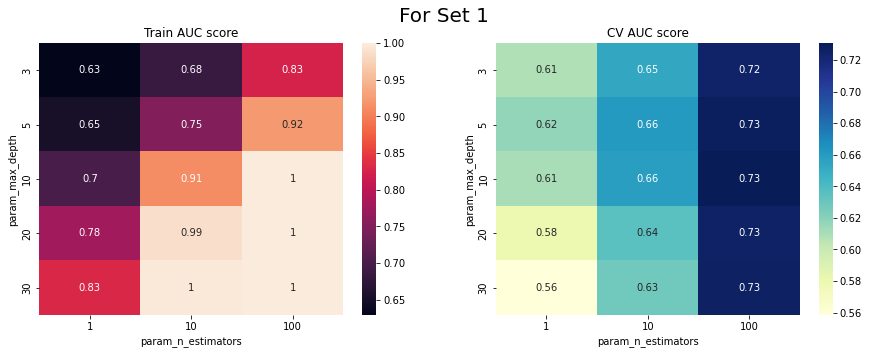

In [ ]:
clf1_results = pd.DataFrame(clf1.cv_results_)
from IPython.core.pylabtools import figsize
train_score_1 = clf1_results['mean_train_score']
cv_score_1 = clf1_results['mean_test_score']
x = clf1_results['param_max_depth']
y = clf1_results['param_n_estimators']
plt.figure(figsize=(15,5))
plt.suptitle('For Set 1',fontsize=20)
plt.subplot(1,2,1)
ax1 = sns.heatmap(clf1_results.pivot("param_max_depth",'param_n_estimators',"mean_train_score"),annot=True)
plt.title('Train AUC score')
plt.subplot(1,2,2)
ax2 = sns.heatmap(clf1_results.pivot("param_max_depth",'param_n_estimators',"mean_test_score"),annot=True,cmap="YlGnBu")
plt.title('CV AUC score')
plt.show()

### Best model parameters

In [ ]:
clf1.best_params_

{'max_depth': 10, 'n_estimators': 100}

## Fitting the best model

In [ ]:
xgb_set1 = xgb.XGBClassifier(max_depth=3,n_estimators=100)
xgb_set1.fit(xtrain_set1,y_train)

XGBClassifier()

## Predicting train and test scores using the best fit model

In [ ]:
y_train_probs = xgb_set1.predict_proba(xtrain_set1)[:,1] # converting train and test output into probability
y_test_probs= xgb_set1.predict_proba(xtest_set1)[:,1]

## ROC Curve

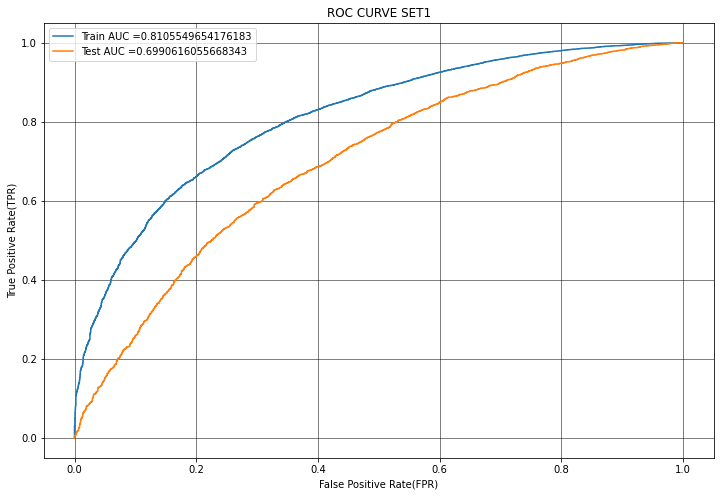

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE SET1")
plt.grid(color='black',lw=0.5)

## Confusion matrix for the best threshold

the maximum value of tpr*(1-fpr) 0.5383808316106145 for threshold 0.833
the maximum value of tpr*(1-fpr) 0.42184619316316585 for threshold 0.844


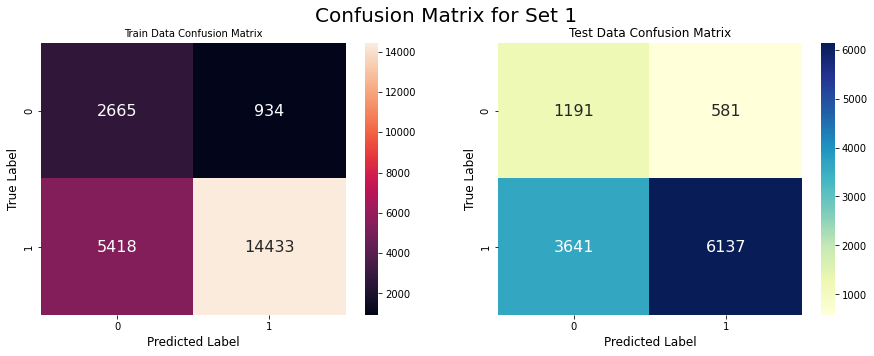

In [ ]:
best_t_train = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm_train=confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t_train))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
best_t_test = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm_test=confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t_test))
# print("CONFUSION MATRIX OF TRAIN DATA")
# print("\n")
# print(cm_train)
# print("CONFUSION MATRIX OF TEST DATA")
# print('\n')
# print(cm_test)
plt.figure(figsize=(15,5))
plt.suptitle('Confusion Matrix for Set 1',fontsize=20)
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, fmt='d',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=10)
plt.subplot(1,2,2)
sns.heatmap(cm_test, annot=True, fmt='d',annot_kws = {"size":16},cmap="YlGnBu")
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)
plt.show()

# Set-2

In [ ]:
import xgboost as xgb
xg = xgb.XGBClassifier()

## Hyperparameter tuning gridsearch

In [ ]:
parameters = {'n_estimators':[1,10,100],'max_depth':[3,5,10,20,30]}
clf2 = GridSearchCV(xg,param_grid=parameters,n_jobs=-1,return_train_score=True,scoring='roc_auc')
clf2.fit(xtrain_set2, y_train)

GridSearchCV(estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 20, 30],
                         'n_estimators': [1, 10, 100]},
             return_train_score=True, scoring='roc_auc')

### Heat map

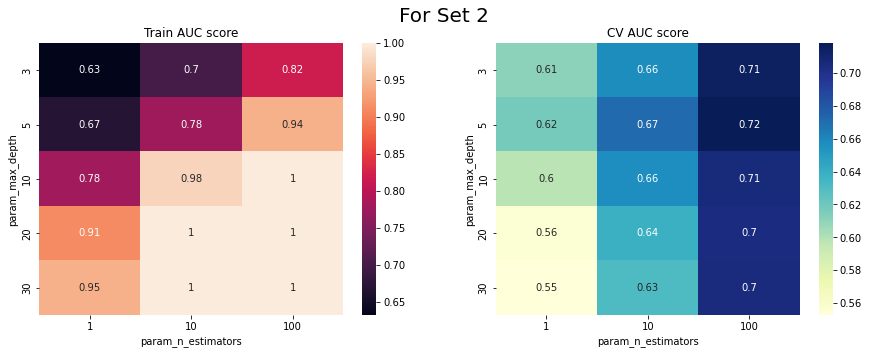

In [ ]:
clf2_results = pd.DataFrame(clf2.cv_results_)
from IPython.core.pylabtools import figsize
train_score_2 = clf2_results['mean_train_score']
cv_score_2 = clf2_results['mean_test_score']
x = clf2_results['param_max_depth']
y = clf2_results['param_n_estimators']
plt.figure(figsize=(15,5))
plt.suptitle('For Set 2',fontsize=20)
plt.subplot(1,2,1)
ax1 = sns.heatmap(clf2_results.pivot("param_max_depth",'param_n_estimators',"mean_train_score"),annot=True)
plt.title('Train AUC score')
plt.subplot(1,2,2)
ax2 = sns.heatmap(clf2_results.pivot("param_max_depth",'param_n_estimators',"mean_test_score"),annot=True,cmap="YlGnBu")
plt.title('CV AUC score')
plt.show()

### Best model parameters

In [ ]:
clf2.best_params_

{'max_depth': 5, 'n_estimators': 100}

## Fitting the best model

In [ ]:
import xgboost as xgb
xgb_set2 = xgb.XGBClassifier(max_depth=5,n_estimators=100)
xgb_set2.fit(xtrain_set2,y_train)

XGBClassifier(max_depth=5)

## Predicting train and test scores using the best fit model

In [ ]:
y_train_probs = xgb_set2.predict_proba(xtrain_set2)[:,1] # converting train and test output into probability
y_test_probs= xgb_set2.predict_proba(xtest_set2)[:,1]

## ROC Curve

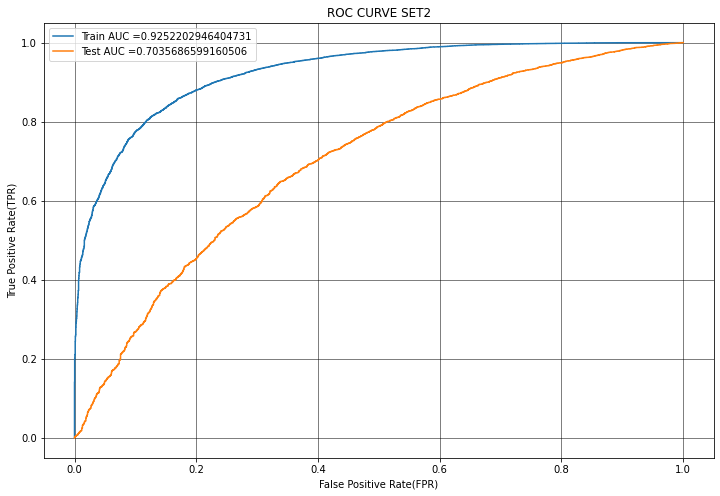

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE SET2")
plt.grid(color='black',lw=0.5)

## Confusion matrix for the best threshold

the maximum value of tpr*(1-fpr) 0.7127739615120142 for threshold 0.801
the maximum value of tpr*(1-fpr) 0.42948444173980654 for threshold 0.819


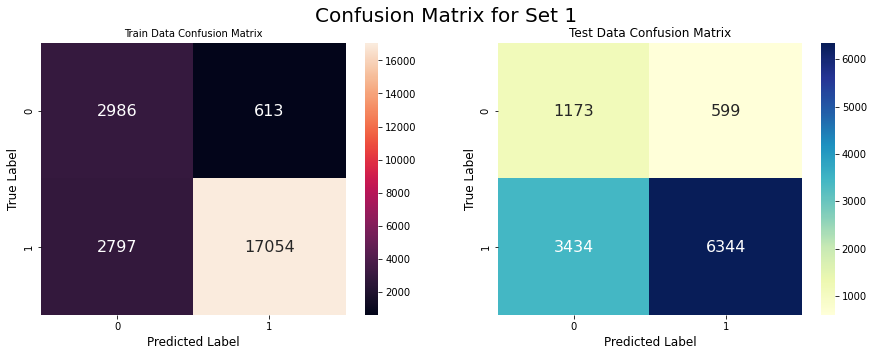

In [ ]:
best_t_train = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm_train=confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t_train))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
best_t_test = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm_test=confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t_test))
# print("CONFUSION MATRIX OF TRAIN DATA")
# print("\n")
# print(cm_train)
# print("CONFUSION MATRIX OF TEST DATA")
# print('\n')
# print(cm_test)
plt.figure(figsize=(15,5))
plt.suptitle('Confusion Matrix for Set 1',fontsize=20)
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, fmt='d',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=10)
plt.subplot(1,2,2)
sns.heatmap(cm_test, annot=True, fmt='d',annot_kws = {"size":16},cmap="YlGnBu")
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)
plt.show()

# Observations

In [ ]:
from prettytable import PrettyTable
from prettytable import ALL as ALL
table=PrettyTable(hrules=ALL)
table.field_names = [ "Sl.N0","Vectorizer", "Model", "Hyper Parameter", "Number of features", "Test-AUC"] # # http://zetcode.com/python/prettytable/
table.add_row([1,"TFIDF", "GBDT", "max_depth =10 , n_estimators=100",5016, 0.6991])
table.add_row([2,"TFIDF W2V", "GBDT"," max_depth =5 , n_estimators=100",316, 0.7035])
print(table)

+-------+------------+-------+----------------------------------+--------------------+----------+
| Sl.N0 | Vectorizer | Model |         Hyper Parameter          | Number of features | Test-AUC |
+-------+------------+-------+----------------------------------+--------------------+----------+
|   1   |   TFIDF    |  GBDT | max_depth =10 , n_estimators=100 |        5016        |  0.6991  |
+-------+------------+-------+----------------------------------+--------------------+----------+
|   2   | TFIDF W2V  |  GBDT |  max_depth =5 , n_estimators=100 |        316         |  0.7035  |
+-------+------------+-------+----------------------------------+--------------------+----------+




*   By using far lesser feature set2 performance is better than set1.
*   And as expected, GBDT performance better and faster when features are less.


